In [1]:
import snowflake.connector
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine

In [2]:
with open("snowflake_password", "r") as file:
    snowflake_password = file.read()
    snowflake_password = snowflake_password.strip()

In [3]:
conn = snowflake.connector.connect(
    user='SUJAYCS',
    password=snowflake_password,
    account='UB31291.us-central1.gcp'
)

cursor = conn.cursor()
cursor.execute("USE DATABASE SURVEY_DATABASE;")
cursor.execute("USE SCHEMA SURVEY_SCHEMA;")

In [1]:
#### Q3: Install DBT using Miniconda

In [4]:
#q3
!which dbt

/home/SujayCS/.local/bin/dbt


In [ ]:
#### Q9: Create survey_transformed view using DBT

In [5]:
#q9 Part 1
!grep -v "password" ~/.dbt/profiles.yml

p4_data_pipeline:
  target: dev # default target; can be switched using --target option of dbt run
  outputs:
    dev:
      type: snowflake
      account: UB31291.us-central1.gcp 
      user: SUJAYCS
      role: P4_ROLE
      database: SURVEY_DATABASE 
      warehouse: P4_WAREHOUSE
      schema: SURVEY_SCHEMA
      threads: 10

    stock_db:
      type: snowflake
      account: UB31291.us-central1.gcp
      user: SUJAYCS
      role: P4_ROLE
      database: STOCK_DB
      warehouse: P4_WAREHOUSE
      schema: STOCK_SCHEMA
      threads: 10


In [6]:
#q9 Part 2
!cat ~/p4_data_pipeline/models/schema.yml

version: 2

sources:
  - name: survey_data
    database: SURVEY_DATABASE
    schema: SURVEY_SCHEMA
    tables:
      - name: survey  # original table from Google Sheets
  - name: stock_by_day
    database: STOCK_TRACKING_US_STOCK_PRICES_BY_DAY
    schema: STOCK
    tables:
      - name: US_STOCK_METRICS
  - name: fx_by_day
    database: FOREX_TRACKING_CURRENCY_EXCHANGE_RATES_BY_DAY
    schema: STOCK
    tables:
      - name: FOREX_METRICS
  - name: airbyte_csv_data
    database: STOCK_DB
    schema: STOCK_SCHEMA
    tables:
      - name: TRADING_BOOKS
      - name: WEIGHTS_TABLE



In [7]:
#q9 Part 3
!cat ~/p4_data_pipeline/models/staging/transform_survey.sql

{{ config(alias='survey_transformed') }}

with raw_survey as (
    select * from {{ source('survey_data', 'survey') }}
),

survey_transformed as (
    select
        {{ adapter.quote('ARE_YOU_A_RUNNER_CONSIDER_BOTH_RUNNING_ON_TREADMILL_AND_OUTDOORS_') }} as is_runner,
        {{ adapter.quote('DO_YOU_CONSIDER_YOURSELF_A_PROCRASTINATOR_') }} as is_procrastinator,
        {{ adapter.quote('EMAIL_ADDRESS') }} as email,
        {{ adapter.quote('HAVE_YOU_EVER_IN_YOUR_LIFE_HAD_A_PET_') }} as has_pet,
        {{ adapter.quote('IF_YOU_HAD_AN_EXTRA_HOUR_IN_YOUR_DAY_HOW_WOULD_YOU_SPEND_IT_') }} as extra_time,
        {{ adapter.quote('IF_YOU_HAVE_SECONDARY_MAJORS_PLEASE_LIST_THEM_HERE_SEPARATED_BY_A_COMMA_') }} as secondary_major,
        {{ adapter.quote('WHAT_FACTOR_INFLUENCES_YOUR_COURSE_SELECTION_THE_MOST_') }} as course_motivation,
        {{ adapter.quote('WHAT_IS_THE_5_DIGIT_ZIP_CODE_OF_YOUR_RESIDENCE_WHILE_ATTENDING_CLASSES_IF_YOU_ARE_NOT_SURE_CHECK_HERE_HTTPS_TOOLS_USPS_COM_ZIP_CODE_LO

In [ ]:
#### Q10: Generate a Pie Chart using Matplotlib to show the distribution of students' current standing

/tmp/ipykernel_9290/360374684.py:8: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


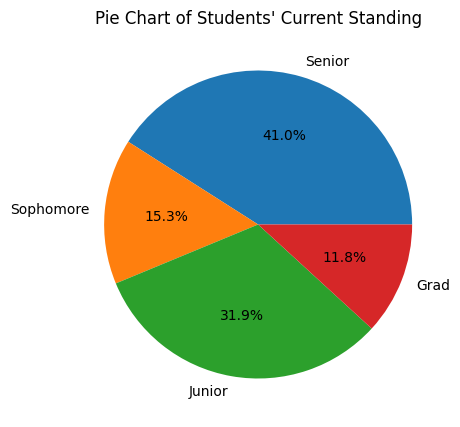

In [8]:
#q10
query = """
SELECT current_standing, COUNT(*) AS count
FROM SURVEY_SCHEMA.SURVEY_TRANSFORMED
GROUP BY current_standing;
"""

df = pd.read_sql(query, conn)
plt.figure(figsize=(5, 5))
plt.pie(df['COUNT'], labels=df['CURRENT_STANDING'], autopct='%1.1f%%')
plt.title("Pie Chart of Students' Current Standing")
plt.show()

In [ ]:
#### Q11: Generate a Histogram using Matplotlib to identify students' motivation for taking the course

/tmp/ipykernel_9290/3525393560.py:8: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


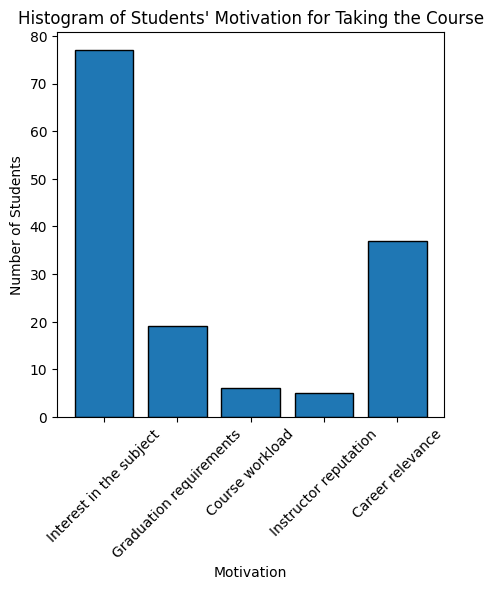

In [9]:
#q11
query = """
SELECT course_motivation, COUNT(*) AS count
FROM SURVEY_SCHEMA.SURVEY_TRANSFORMED
GROUP BY course_motivation;
"""

df = pd.read_sql(query, conn)
df
plt.figure(figsize=(5, 5))
plt.bar(df['COURSE_MOTIVATION'], df['COUNT'], edgecolor='black')
plt.title("Histogram of Students' Motivation for Taking the Course")
plt.xlabel("Motivation")
plt.ylabel("Number of Students")
plt.xticks(rotation=45)
plt.show()

In [ ]:
#### Q12: How many students have had pets before?

In [10]:
#q12
query = """
SELECT has_pet, COUNT(*) AS count
FROM SURVEY_SCHEMA.SURVEY_TRANSFORMED
GROUP BY has_pet 
HAVING has_pet = 'Yes';
"""

df = pd.read_sql(query, conn)
df['COUNT']

/tmp/ipykernel_9290/2800343809.py:9: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


0    106
Name: COUNT, dtype: int64

In [ ]:
#### Q13: What are the top 5 hobbies among students?

In [11]:
#q13
query = """
SELECT favourite_hobby, COUNT(*) AS count
FROM SURVEY_SCHEMA.SURVEY_TRANSFORMED
GROUP BY favourite_hobby
ORDER BY count DESC
LIMIT 5;
"""

df = pd.read_sql(query, conn)
df['FAVOURITE_HOBBY']

/tmp/ipykernel_9290/757217326.py:10: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


0       Reading
1    basketball
2        Guitar
3    Basketball
4       Drawing
Name: FAVOURITE_HOBBY, dtype: object

In [ ]:
#### Q14: Find the most popular pizza topping

In [12]:
#q14
query = """
SELECT favourite_topping, COUNT(*) AS count
FROM SURVEY_SCHEMA.SURVEY_TRANSFORMED
GROUP BY favourite_topping
ORDER BY count DESC
LIMIT 1;
"""

df = pd.read_sql(query, conn)
df['FAVOURITE_TOPPING']

/tmp/ipykernel_9290/2266629979.py:10: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


0    pepperoni
Name: FAVOURITE_TOPPING, dtype: object

In [ ]:
#### Q15: Find the percentage of students falling into each chronotype category (early bird/ night owl/ no pref)

In [13]:
#q15
query = """
SELECT chronotype,
    COUNT(*) * 100.0 / SUM(COUNT(*)) OVER () AS percentage
FROM SURVEY_SCHEMA.SURVEY_TRANSFORMED
GROUP BY chronotype
ORDER BY percentage DESC;
"""

df = pd.read_sql(query, conn)
df

/tmp/ipykernel_9290/4003078061.py:10: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


,CHRONOTYPE,PERCENTAGE
0,night owl,61.805556
1,early bird,22.916667
2,no preference,15.277778


In [ ]:
#### Q16: What is the average age of students who consider themselves procrastinators versus non-procrastinators?

In [14]:
#q16
query = """
SELECT is_procrastinator, AVG(age) AS average_age
FROM SURVEY_SCHEMA.SURVEY_TRANSFORMED
WHERE is_procrastinator NOT LIKE 'Maybe'
GROUP BY is_procrastinator;
"""

df = pd.read_sql(query, conn)
df

/tmp/ipykernel_9290/1595564160.py:9: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


,IS_PROCRASTINATOR,AVERAGE_AGE
0,No,21.805556
1,Yes,21.064935


In [ ]:
#### Q18: Configure DBT profile for stock_db

In [15]:
#q18
!grep -v "password" ~/.dbt/profiles.yml

p4_data_pipeline:
  target: dev # default target; can be switched using --target option of dbt run
  outputs:
    dev:
      type: snowflake
      account: UB31291.us-central1.gcp 
      user: SUJAYCS
      role: P4_ROLE
      database: SURVEY_DATABASE 
      warehouse: P4_WAREHOUSE
      schema: SURVEY_SCHEMA
      threads: 10

    stock_db:
      type: snowflake
      account: UB31291.us-central1.gcp
      user: SUJAYCS
      role: P4_ROLE
      database: STOCK_DB
      warehouse: P4_WAREHOUSE
      schema: STOCK_SCHEMA
      threads: 10


In [ ]:
#### Q19: Update models/schema.yml file to include second source

In [16]:
#q19
!cat ~/p4_data_pipeline/models/schema.yml

version: 2

sources:
  - name: survey_data
    database: SURVEY_DATABASE
    schema: SURVEY_SCHEMA
    tables:
      - name: survey  # original table from Google Sheets
  - name: stock_by_day
    database: STOCK_TRACKING_US_STOCK_PRICES_BY_DAY
    schema: STOCK
    tables:
      - name: US_STOCK_METRICS
  - name: fx_by_day
    database: FOREX_TRACKING_CURRENCY_EXCHANGE_RATES_BY_DAY
    schema: STOCK
    tables:
      - name: FOREX_METRICS
  - name: airbyte_csv_data
    database: STOCK_DB
    schema: STOCK_SCHEMA
    tables:
      - name: TRADING_BOOKS
      - name: WEIGHTS_TABLE



In [ ]:
#### Q20: Create dbt_project.yml file in your dbt project directory

In [17]:
#q20
!cat ~/p4_data_pipeline/dbt_project.yml


# Name your project! Project names should contain only lowercase characters
# and underscores. A good package name should reflect your organization's
# name or the intended use of these models
name: 'p4_data_pipeline'
version: '1.0.0'

# This setting configures which "profile" dbt uses for this project.
profile: 'p4_data_pipeline'

# These configurations specify where dbt should look for different types of files.
# The `model-paths` config, for example, states that models in this project can be
# found in the "models/" directory. You probably won't need to change these!
model-paths: ["models"]
analysis-paths: ["analyses"]
test-paths: ["tests"]
seed-paths: ["seeds"]
macro-paths: ["macros"]
snapshot-paths: ["snapshots"]

clean-targets:         # directories to be removed by `dbt clean`
  - "target"
  - "dbt_packages"


# Configuring models
# Full documentation: https://docs.getdbt.com/docs/configuring-models

# In this example config, we tell dbt to build all models in the example/
# di

In [ ]:
#### Q21: Creating staging tables for FX and Stock

In [18]:
#q21 Part 1
!cat ~/p4_data_pipeline/models/staging/staging_valid_fx_tickers.sql

with raw_fx_data as (
    select * from {{ source('fx_by_day', 'FOREX_METRICS') }}
),

valid_tickers as (
    select * from {{ source('airbyte_csv_data', 'TRADING_BOOKS') }}
),

staging_valid_fx_tickers as (
    select rf.*
    from raw_fx_data rf
    inner join valid_tickers vt
        on rf.CURRENCY_PAIR_NAME = vt.TICKER and 
        rf.RUN_DATE = vt.TRADE_DATE
)

select DISTINCT RUN_DATE, CURRENCY_PAIR_NAME from staging_valid_fx_tickers


In [19]:
#q21 Part 2
!cat ~/p4_data_pipeline/models/staging/staging_valid_stock_tickers.sql

with raw_stock_data as (
    select * from {{ source('stock_by_day', 'US_STOCK_METRICS') }}
),

valid_tickers as (
    select * from {{ source('airbyte_csv_data', 'TRADING_BOOKS') }}
),

staging_valid_stock_tickers as (
    select rs.*
    from raw_stock_data rs
    inner join valid_tickers vt
        on rs.TICKER = vt.TICKER and
        rs.RUN_DATE = vt.TRADE_DATE
)

select DISTINCT RUN_DATE, TICKER from staging_valid_stock_tickers


In [20]:
#q21 Part 3
!cat ~/p4_data_pipeline/models/staging/staging_valid_fx_info.sql

with selected_tickers as (
    select DISTINCT RUN_DATE, CURRENCY_PAIR_NAME
    from {{ ref('staging_valid_fx_tickers') }}
),

fx_info as (
    select
        st.RUN_DATE,
        st.CURRENCY_PAIR_NAME,
        rf.OPEN,
        rf.CLOSE,
        rf.HIGH,
        rf.LOW
    from selected_tickers st
    inner join {{ source('fx_by_day', 'FOREX_METRICS') }} rf
        on st.RUN_DATE = rf.RUN_DATE
        and st.CURRENCY_PAIR_NAME = rf.CURRENCY_PAIR_NAME
)

select * from fx_info


In [21]:
#q21 Part 4
!cat ~/p4_data_pipeline/models/staging/staging_valid_stock_info.sql

with selected_tickers as (
    select DISTINCT RUN_DATE, TICKER
    from {{ ref('staging_valid_stock_tickers') }}
),

stock_info as (
    select
        st.RUN_DATE,
        st.TICKER,
        rs.OPEN,
        rs.CLOSE,
        rs.HIGH,
        rs.LOW
    from selected_tickers st
    inner join {{ source('stock_by_day', 'US_STOCK_METRICS') }} rs
        on st.RUN_DATE = rs.RUN_DATE
        and st.TICKER = rs.TICKER
)

select * from stock_info


In [22]:
#q21 Part 5
views = [
    "staging_valid_fx_tickers",
    "staging_valid_stock_tickers",
    "staging_valid_fx_info",
    "staging_valid_stock_info"
]

for view in views:
    query = f"SELECT * FROM {view}"
    df = pd.read_sql(query, conn)
    csv_path = f"files/{view}.csv"
    df.to_csv(csv_path, index=False)

/tmp/ipykernel_9290/754386856.py:11: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


In [ ]:
#### Q22: Creating staging table for trading pairs

In [23]:
#q22 Part 1
!cat ~/p4_data_pipeline/models/staging/staging_buy_sell_joint.sql

with raw_trading_books as (
    select * from {{ source('airbyte_csv_data', 'TRADING_BOOKS') }}
),

buy_trades as (
    select
        TRADE_ID as buy_trade_id,
        TRADE_DATE,
        TRADER_NAME,
        DESK,
        TICKER,
        QUANTITY as quantity_buy,
        PRICE as price_buy
    from raw_trading_books
    where TRADE_TYPE = 'BUY'
),

sell_trades as (
    select
        TRADE_ID as sell_trade_id,
        TRADE_DATE,
        TRADER_NAME,
        DESK,
        TICKER,
        QUANTITY as quantity_sell,
        PRICE as price_sell
    from raw_trading_books
    where TRADE_TYPE = 'SELL'
),

staging_buy_sell_joint as (
    select
        bt.buy_trade_id as trade_id,
        bt.TRADE_DATE,
        bt.TRADER_NAME,
        bt.DESK,
        bt.TICKER,
        bt.quantity_buy,
        bt.price_buy,
        st.quantity_sell,
        st.price_sell
    from buy_trades bt
    inner join sell_trades st
        on bt.TRADER_NAME = st.TRADER_NAME
        and bt.TICKER = st.TICKER
     

In [24]:
#q22 Part 2
views = [
    "staging_buy_sell_joint"
]

for view in views:
    query = f"SELECT * FROM {view}"
    df = pd.read_sql(query, conn)
    csv_path = f"files/{view}.csv"
    df.to_csv(csv_path, index=False)

/tmp/ipykernel_9290/4003872278.py:8: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


In [ ]:
#### Q23: Create a fact table for trading data

In [25]:
#q23 Part 1
!cat ~/p4_data_pipeline/models/marts/fact_tab_trading.sql

with staging_buy_sell_joint as (
    select *
    from {{ ref('staging_buy_sell_joint') }}
),

fact_trading_data as (
    select
        trade_id,
        ROUND(quantity_buy * price_buy, 2) as buy_money,
        ROUND(quantity_sell * price_sell, 2) as sell_money,
        ROUND(ROUND(quantity_sell * price_sell, 2) - ROUND(quantity_buy * price_buy,2), 2) as profit
    from staging_buy_sell_joint
)

select * from fact_trading_data order by trade_id

In [26]:
#q23 Part 2
tables = [
    "fact_tab_trading"
]

for table in tables:
    query = f"SELECT * FROM {table}"
    df = pd.read_sql(query, conn)
    csv_path = f"files/{table}.csv"
    df.to_csv(csv_path, index=False)

/tmp/ipykernel_9290/2326838150.py:8: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


In [ ]:
#### Q24: Compute total profit by desk

In [27]:
#q24
query = """
SELECT tb.DESK, ROUND(sum(td.PROFIT), 2) as TOTAL_PROFIT
FROM STOCK_DB.STOCK_SCHEMA.TRADING_BOOKS tb
JOIN FACT_TAB_TRADING td
ON tb.TRADE_ID = td.TRADE_ID
GROUP BY tb.DESK;
"""

df = pd.read_sql(query, conn)
df

/tmp/ipykernel_9290/674559044.py:10: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


,DESK,TOTAL_PROFIT
0,Equity Desk,2718.75
1,FX Desk,5000.00


In [ ]:
#### Q25: Compute profit rate by desk

In [28]:
#q25
query = """
SELECT tb.DESK, ROUND((sum(td.sell_money) - sum(td.buy_money)) / NULLIF(sum(td.buy_money), 0), 4) as total_profit_rate
FROM STOCK_DB.STOCK_SCHEMA.TRADING_BOOKS tb
JOIN FACT_TAB_TRADING td
ON tb.TRADE_ID = TD.TRADE_ID
GROUP BY TB.DESK;
"""

df = pd.read_sql(query, conn)
df

/tmp/ipykernel_9290/711105883.py:10: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


,DESK,TOTAL_PROFIT_RATE
0,Equity Desk,0.0127
1,FX Desk,0.0063
